# Baseline Clustering Model

In this notebook we aim to :
* Build a baseline model with K-means clustering and attempt optmizing it 
* try TSNE
* a copy of feature engineering notebook would be made by name of "Feature Engineering ( for turning)"
* try PCA in different ways 
    * once with no pca 
    * once perfrom PCA on entire data
    * once perfrom PCA on each section of survey alone 
* try other models than k-means 




*NEXT NOTEBOOK* : Deep Clustering

In [1]:
# imports
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import sklearn 
from sklearn.cluster import KMeans as k_means_sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from  scipy.cluster.vq import kmeans 
from  scipy.cluster.vq import cdist
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    

In [2]:
data=pd.read_csv("checkpoint_final.csv")
data.shape

(2441, 976)

### K means

In [4]:
data.drop("PatientID",inplace=True,axis=1)

In [5]:
X=np.array(data)

Text(0.5, 1.0, 'Elbow for KMeans clustering')

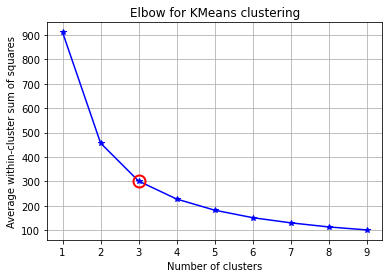

In [11]:
### how many clusters? a common empirical method is elbow method


##a quick yet amazing implementation I grapbbed from stackoverflow response:
#here https://stackoverflow.com/questions/6645895/calculating-the-percentage-of-variance-measure-for-k-means


##### cluster data into K=1..10 clusters #####
K = range(1,10)

# scipy.cluster.vq.kmeans
KM = [kmeans(X,k) for k in K]
centroids = [cent for (cent,var) in KM]   # cluster centroids
#avgWithinSS = [var for (cent,var) in KM] # mean within-cluster sum of squares

# alternative: scipy.spatial.distance.cdist
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

##### plot ###
kIdx = 2

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

Ok our elbow is at 3 dimensions so this is what we will be working on 

In [6]:
### first build our first kmeans with the data as is 
model=k_means_sklearn(n_clusters=3,random_state=42,max_iter=300)
labels=model.fit_predict(X)
print(silhouette_score(X,labels))
##coherence 

0.5927473441522683


well 0.59 of a silhoute score is not bad at all , let's try to visualize that with a little dimensionality reduction using TSNE

In [7]:
data["cluster"]=labels

In [8]:
tsne2d=TSNE(n_components=2)
tsne3d=TSNE(n_components=3)

data_2d=tsne2d.fit_transform(X)
data_3d=tsne3d.fit_transform(X)

<AxesSubplot:>

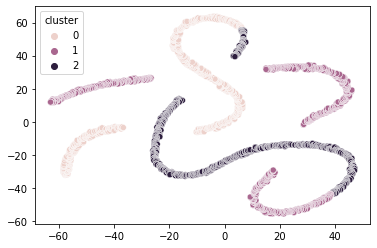

In [9]:
### 2d plot 
sns.scatterplot(x=data_2d[:,0],y=data_2d[:,1],hue=data["cluster"])

In [11]:
### 3d plot
sns.set(style = "darkgrid")
%matplotlib osx
fig = plt.figure(figsize=(30,20))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(data_3d[:,0],data_3d[:,1],data_3d[:,2],c=data["cluster"])

In [12]:
### 3d plot
from matplotlib import cm
sns.set(style = "darkgrid")
plt.style.use("ggplot")
%matplotlib osx
fig = plt.figure(figsize=(30,20))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(data_3d[:,0],data_3d[:,1],data_3d[:,2],c=data["cluster"],cmap=cm.Dark2)


### Some descriptive statistics on individual clusters

In [61]:
data_orginal=pd.read_csv("data_pooled_cleaned.csv")
data_orginal.shape

(2571, 773)

In [ ]:
cluster_df=data[["PatientID","cluster"]]
data_orginal=data_orginal.merge(cluster_df,right_on="PatientID",left_on="PatientID")

In [63]:
data_orginal.shape

(2441, 774)

In [84]:
def compare_cluster(var,df):
    cluster0=df[df.cluster==0]
    cluster1=df[df.cluster==1]
    cluster2=df[df.cluster==2]
    if pd.api.types.is_numeric_dtype(df[var]):
        print(f"Mean of cluster 0 is {np.mean(cluster0[var]):.2f} +/- {np.std(cluster0[var]):.2f}")
        print(f"Mean of cluster 1 is {np.mean(cluster1[var]):.2f} +/- {np.std(cluster1[var]):.2f}")
        print(f"Mean of cluster 2 is {np.mean(cluster2[var]):.2f} +/- {np.std(cluster2[var]):.2f}")
        sns.barplot(df["cluster"],df[var])
    elif pd.api.types.is_object_dtype(df[var]):
        print("Cluster 0\n")
        print(cluster0[var].value_counts()/len(cluster0))
        print("Cluster 1\n")
        print(cluster1[var].value_counts()/len(cluster1))
        print("Cluster 2\n")
        print(cluster2[var].value_counts()/len(cluster2))
        

In [78]:
compare_cluster("sex_demo",data_orginal)

Cluster 0

 Female    0.571429
 Male      0.423515
Name: sex_demo, dtype: float64
Cluster 1

 Female    0.571938
 Male      0.426873
Name: sex_demo, dtype: float64
Cluster 2

 Female    0.542645
 Male      0.453646
Name: sex_demo, dtype: float64


In [80]:
compare_cluster("age_group_demo",data_orginal)

Cluster 0

 18-29    0.548673
 30-39    0.158028
 50-59    0.111252
 40-49    0.098609
 60-69    0.045512
 70-79    0.021492
 80+      0.002528
Name: age_group_demo, dtype: float64
Cluster 1

 18-29    0.639715
 30-39    0.098692
 50-59    0.092747
 40-49    0.085612
 60-69    0.034483
 70-79    0.029727
 80+      0.003567
Name: age_group_demo, dtype: float64
Cluster 2

 18-29    0.490729
 30-39    0.127318
 40-49    0.126082
 50-59    0.124845
 60-69    0.069221
 70-79    0.033375
 80+      0.012361
Name: age_group_demo, dtype: float64


In [85]:
compare_cluster("weight_demo",data_orginal)

Mean of cluster 0 is 73.16 +/- 39.05
Mean of cluster 1 is 72.47 +/- 37.19
Mean of cluster 2 is 73.45 +/- 18.52


In [86]:
compare_cluster("country_demo",data_orginal)

Cluster 0

egypt          0.297092
pakistan       0.204804
afghanistan    0.149178
iran           0.116308
palestine      0.050569
syria          0.048040
india          0.027813
yemen          0.026549
algeria        0.020228
ksa            0.013906
libya          0.012642
sudan          0.008850
uae            0.006321
usa            0.005057
germany        0.003793
uk             0.002528
lebanon        0.001264
oman           0.001264
tunisia        0.001264
Name: country_demo, dtype: float64
Cluster 1

india        0.405470
egypt        0.323424
syria        0.084423
pakistan     0.042806
yemen        0.040428
algeria      0.034483
qatar        0.019025
ksa          0.011891
turkey       0.008323
usa          0.007134
uae          0.007134
germany      0.002378
australia    0.002378
italy        0.002378
kuwait       0.001189
scotland     0.001189
canada       0.001189
libya        0.001189
russia       0.001189
bahrain      0.001189
Name: country_demo, dtype: float64
Cluster 2

s

In [89]:
def return_certain_section(section):
    return data_orginal[[x for x in data_orginal.columns if section in x]]
data_treat=return_certain_section("treat")
data_treat

,hospitalized_treatment,hospitlization_duration_treatment,oxygen_support_treatment,OTC_prescription_alternate_use_treatment,vaccine_treatment,Type of the vaccine_treatment,vaccine_shots_treatment,vaccine_date_treatment,infection_post_vaccination_treatment,Anti-histamines_treatment,...,Over the counter painkillers_treatment,Oxaloacetate_treatment,Remsdesevir_treatment,Rivaroxaban_treatment,Steroids_treatment,Ticagrelor_treatment,Veklury_treatment,Warfarin_treatment,Vitamin C_treatment,Zinc_treatment
0, No,NaN,NaN,"Antibiotics,Aspirin,Anti-histamines,NSAIDs",Yes, COVID-19 Vaccine AstraZeneca (AZD1222); also...,NaN,2021-11-15,No,1,...,0,0,0,0,0,0,0,0,0,0
1, No,NaN, No,"Anti-histamines,Antibiotics",Yes, COVID-19 Vaccine AstraZeneca (AZD1222); also...,NaN,NaN,Yes,1,...,0,0,0,0,0,0,0,0,0,0
2, No,NaN, No,None,Yes, CoronaVac (Sinovac),NaN,2021-04-03,Yes,0,...,0,0,0,0,0,0,0,0,0,0
3, No,NaN, No,Azithromycin,Yes, CoronaVac (Sinovac),NaN,2021-04-19,Yes,0,...,0,0,0,0,0,0,0,0,0,0
4, No,NaN, No,"Curcumin,Others,Azithromycin,NSAIDs",Yes, CoronaVac (Sinovac),NaN,2021-02-13,Yes,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2436, No,NaN, I was not hospitalized,"Azithromycin,Antibiotics,Steroids,Anti-histami...",Yes, CoronaVac (Sinovac),NaN,2021-09-21,No,1,...,0,0,0,0,1,0,0,0,0,0
2437, Yes,NaN," Yes, nasal cannula","Enoxaparin,NSAIDs",Yes," Comirnaty (BNT162b2) ( Pfizer, BioNTech; Fos...",NaN,2021-09-01,Yes,0,...,0,0,0,0,0,0,0,0,0,0
2438, Yes,NaN," Yes, I was intubated","Steroids,Anti-histamines,Enoxaparin",Yes," Comirnaty (BNT162b2) ( Pfizer, BioNTech; Fos...",NaN,2021-07-11,No,1,...,0,0,0,0,1,0,0,0,0,0
2439, No,NaN, I was not hospitalized,"Aspirin,H1 type Antihistamines,Antibiotics",Yes," Comirnaty (BNT162b2) ( Pfizer, BioNTech; Fos...",NaN,2020-12-20,Yes,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
compare_cluster("Type of the vaccine_treatment",data_orginal)

Cluster 0

 CoronaVac (Sinovac)                                                                                          0.217446
 BBIBP-CorV (Beijing Institute of Biological Products; China National Pharmaceutical Group (Sinopharm))       0.170670
 COVID-19 Vaccine AstraZeneca (AZD1222); also known as Vaxzevria and Covishield ( BARDA, OWS)                 0.166877
 Comirnaty (BNT162b2) ( Pfizer, BioNTech; Fosun Pharma)                                                       0.085967
 COVID-19 Vaccine Janssen (JNJ-78436735; Ad26.COV2.S) (Janssen Vaccines (Johnson & Johnson)                   0.042984
 Sputnik V ( Gamaleya Research Institute, Acellena Contract Drug Research and Development, Russia)            0.030341
 Sputnik Light ( Gamaleya Research Institute, Acellena Contract Drug Research and Development, Russia)        0.020228
 Moderna COVID‑19 Vaccine (mRNA-1273); also called Spikevax ( Moderna, BARDA, NIAID)                          0.017699
 Convidicea (PakVac, Ad5-nCo

In [93]:
compare_cluster("vaccine_shots_treatment",data_orginal)

Mean of cluster 0 is 1.65 +/- 0.51
Mean of cluster 1 is 2.09 +/- 0.46
Mean of cluster 2 is 2.36 +/- 0.76


In [207]:
def count_dummy_per_cluster(section):
    cluster0=data_orginal[data_orginal.cluster==0]
    cluster1=data_orginal[data_orginal.cluster==1]
    cluster2=data_orginal[data_orginal.cluster==2]
    clusters=[cluster0,cluster1,cluster2]
    cols=[x for x in data_orginal.columns if section in x]
    dummy_cols=[]
    for col in cols:
        if data_orginal[col].nunique()<=2 and pd.api.types.is_numeric_dtype(data_orginal[col]):
            dummy_cols.append(col)
    plt.figure(figsize=(30,10))
    for e,cluster in enumerate(clusters):
        ax=plt.subplot(1,3,e+1)
        summs={}
        for col in dummy_cols:
            try:
                col_name=col.replace(section,"")
                summs[col_name]=np.sum(cluster[col])
                summs={k: v for k, v in sorted(summs.items(), key=lambda item: item[1],reverse=True)}
            except:
                pass
        #print(summs)
        ax.bar(list(summs.keys())[:20],height=list(summs.values())[:20])
        ax.set_title(f"Cluster{e}")
        ax.set_xticks(list(summs.keys())[:20],rotation=90)
        plt.xticks(rotation=90)
    
    plt.show()
        
                
                
        
    
    

In [208]:
dic={3:4,5:5}
dic.values()


dict_values([4, 5])

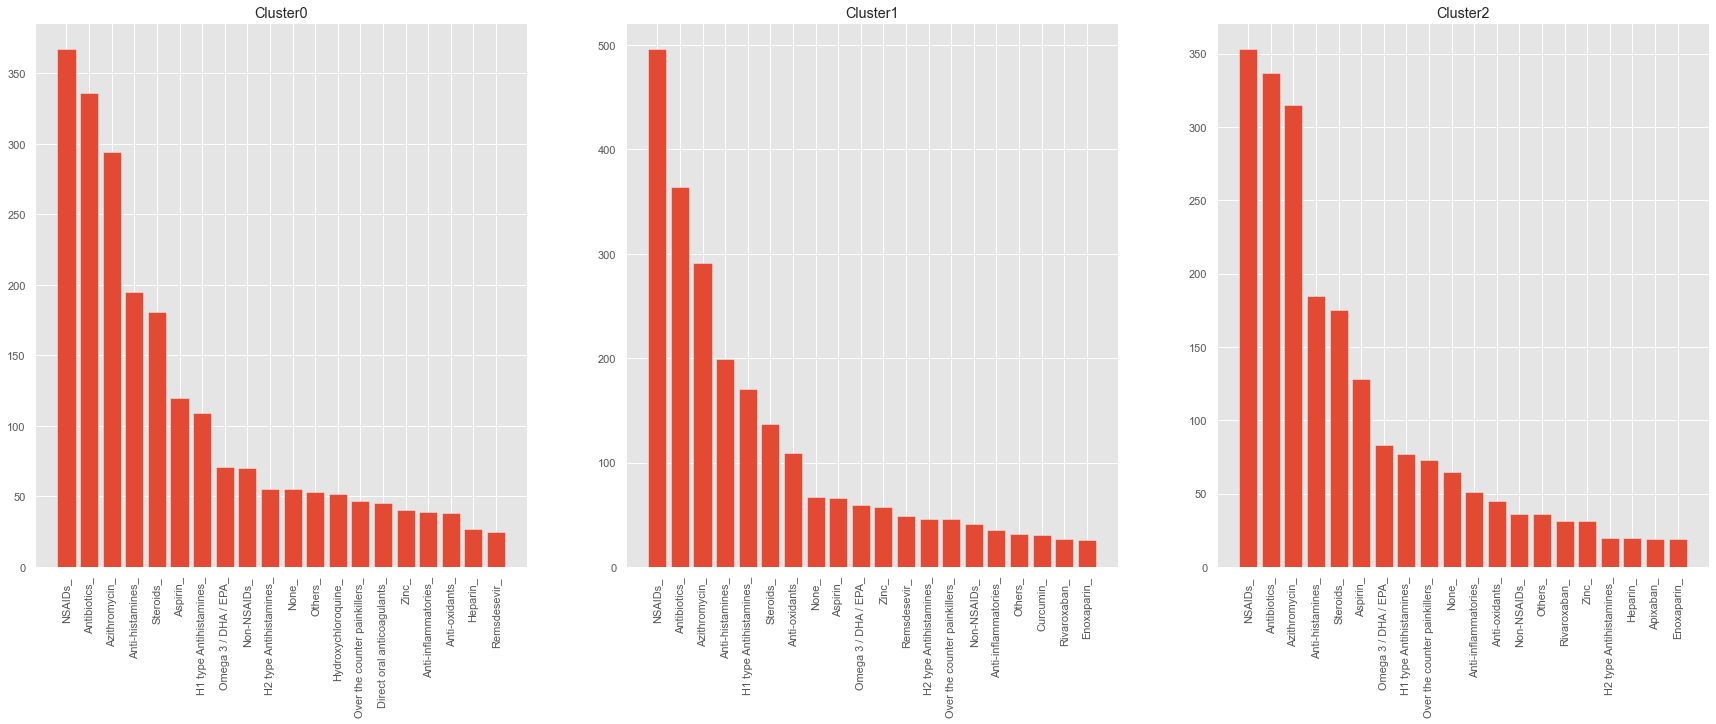

In [209]:
%matplotlib inline
count_dummy_per_cluster("treatment")

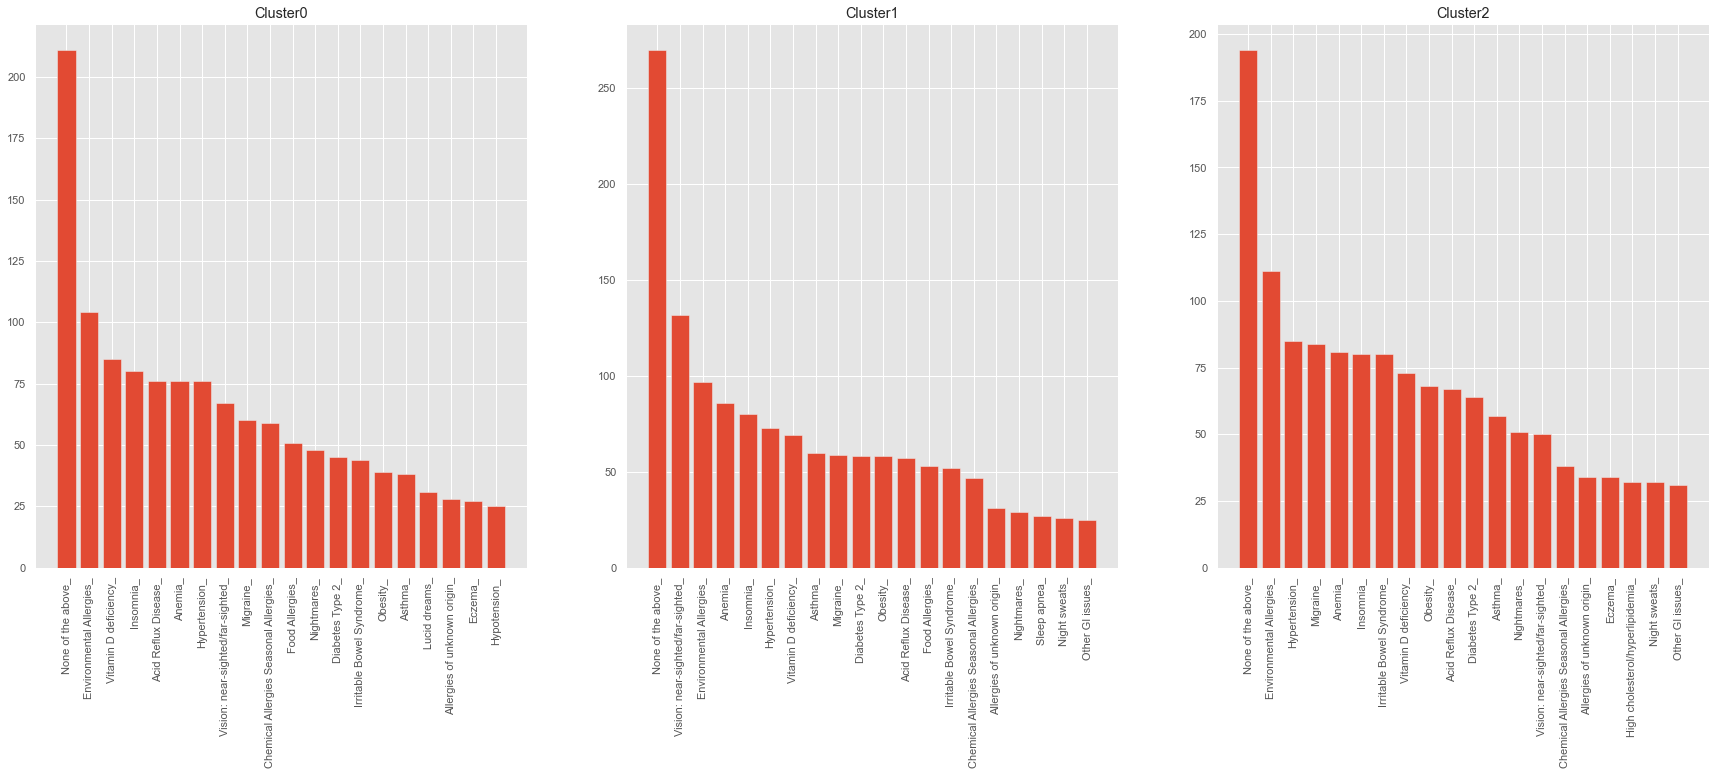

In [210]:
count_dummy_per_cluster("covid")